# Hyperparameter Tuning for RoBERTa
To further improve the strong performance of the RoBERTa model on the classification task, we experimented with hyperparameter tuning (hpt).

We use the wandb.ai developer tools integration of the simpletransformers library to keep track of the statistics during sweeps. wandb.ai provides very convenient visualization tools that help us evaluating the tuning efforts.


 
## Setup
* We tried to optimize accuracy over <br>
training epochs (1 to 40) and <br>
learning rate (0 to 0.0004). 
* We use an early stopping criterion which ends training if accuracy has not improved by 0.01 over 5 training steps.
* To avoid hyperparameter tuning to take several weeks a GPU is mandatory. We used google Colab's environment which offers GPU usage for free.


## Results

*  Hyperparemter tuning sugguests picking low learning rates (<0.00005) with modest training epochs (around 15) (see the graph below)
*  With a training / evaluation data split of 0.95 and 0.05 on the training data, evaluation showed promising results with accuracy scores above 0.80.
*  Unfortunately, using these hyperparameters did not improve the performance on the test data, and we therefore stick with simple fine tuning of the RoBERTa model with default parameters.


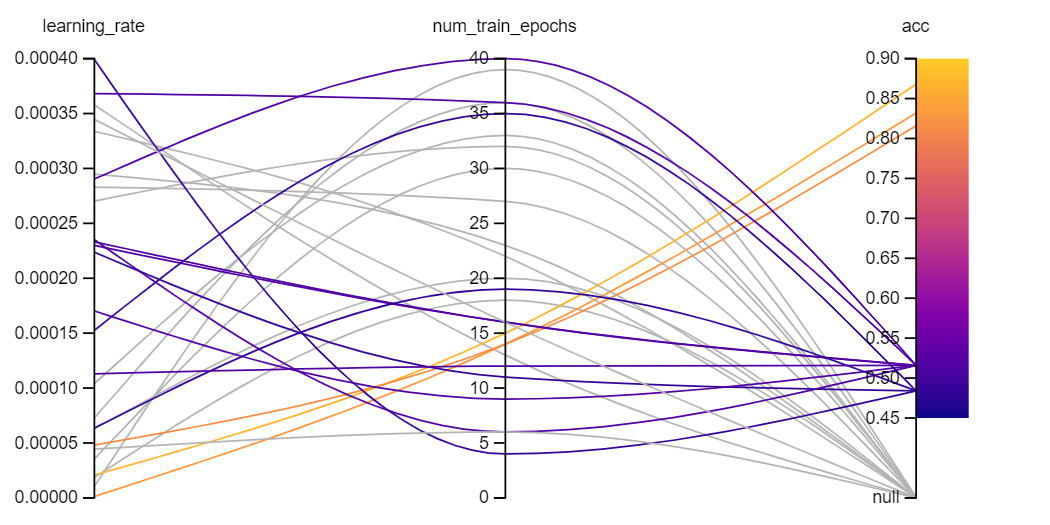



You can see the full output reported to wandb.ai here:
https://wandb.ai/mattzee/TwitterSarcasmComp%20-%20Hyperparameter%20Optimization2



## Challenges


*   The optimizer is very sensitive to parameters, if the setup is not correct hpt aborts with CUDA memory error (see e.g. https://github.com/ThilinaRajapakse/simpletransformers/pull/829)
*   Google Colab has frequently stopped execution, possible due to an extended run time of the optimizer or no user interaction
*   We were able to produce some results, but hpt was never truely finalized on google colab


## References
https://simpletransformers.ai/docs/tips-and-tricks/ <br>
https://docs.wandb.com/integrations/simpletransformers <br>
https://towardsdatascience.com/hyperparameter-optimization-for-optimum-transformer-models-b95a32b70949


# Code

##Colab Phython Setup

###Connect to google drive and set the correct working directory


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/TxtClassComp_MattzeePrivate/')

In [ ]:
!pwd 

/content/gdrive/MyDrive/TxtClassComp_MattzeePrivate


### Install required libraries/frameworks

In [ ]:
!pip install jsonlines
!pip install pandas

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 204kB 8.9MB/s 
     |████████████████████████████████| 7.4MB 12.3MB/s 
     |████████████████████████████████| 317kB 45.4MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 1.4MB 52.8MB/s 
     |████████████████████████████████| 1.1MB 54.4MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 2.9MB 48.4MB/s 
     |████████████████████████████████| 1.8MB 19.0MB/s 
     |████████████████████████████████| 4.5MB 3.3MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
     |████████████████████████████████| 163kB 51.1MB/s 
     |████████████████████████████████| 112kB 60.6MB/s 
     |████████████████████████████████| 890kB 46.1MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 133kB 58.5MB/s 
     |████████████████████████████████| 122kB 58.9MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 

### Load libraries

In [ ]:
from simpletransformers.classification import ClassificationModel,ClassificationArgs
import pandas as pd
import numpy as np
import logging
import json
import sklearn
from statistics import mean, mode
import os
#import json
import jsonlines
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support


## Load and prepare the data

In [ ]:
test_file = '/content/gdrive/MyDrive/TxtClassComp_MattzeePrivate/data/test.jsonl'
train_file = '/content/gdrive/MyDrive/TxtClassComp_MattzeePrivate/data/train.jsonl'

data_train = []
iter = 1
with jsonlines.open(train_file) as f:
    for line in f.iter():
        #data = json.load(line)
        #print(line) # or whatever else you'd like to do
        #print('processing training line: ' + str(iter))
        iter +=1
        data_train.append(line)
        #data = json.loads(line)
        #print(data)


data_test = []
iter = 1
with jsonlines.open(test_file) as f:
    for line in f.iter():
        #data = json.load(line)
        #print(line) # or whatever else you'd like to do
        #print('processing test line: ' + str(iter))
        iter +=1
        data_test.append(line)
        #data = json.loads(line)
        #print(data)
print("Count of training data entries:")
print(len(data_train))
print("Count of test data entries:")
print(len(data_test))

Count of training data entries:
5000
Count of test data entries:
1800


In [ ]:
train_data_pd = pd.DataFrame.from_dict(data_train)
test_data_pd = pd.DataFrame.from_dict(data_test)
print("Training and Test Datasets converted to Pandas DataFrames...")

Training and Test Datasets converted to Pandas DataFrames...


In [ ]:
#!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, SpaceTokenizer
from nltk.stem import PorterStemmer

#print(stopwords.words('english'))

#for j in stopwords.words('english'):
#    print(j)

#print(stopwords.words())




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:

#print(train_data_pd['context'][1])
#print(train_data_pd['response'][1])
#print(train_data_pd['context'][1][0]+train_data_pd['context'][1][1])
#print(len(train_data_pd['context'][3040]))

#test = train_data_pd['context'][10][0] + train_data_pd['context'][10][1] +train_data_pd['response'][10]
#print(test)
#test2 = train_data_pd['context'][:][0] + train_data_pd['context'][:][1] +train_data_pd['response']
all_stopwords = stopwords.words('english')
tk = SpaceTokenizer() 
ps = PorterStemmer()

for i in range(len(train_data_pd)):
    #train_data_pd['response'][i]=train_data_pd['response'][i]+train_data_pd['context'][i][0] + train_data_pd['context'][i][1]
    train_data_pd['response'][i]=train_data_pd['response'][i]+train_data_pd['context'][i][1]
    train_data_pd['response'][i]=train_data_pd['response'][i].replace('@USER', '').strip().lower()    
    text_tokens = tk.tokenize(train_data_pd['response'][i])
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    test4=""
    for i in tokens_without_sw:
        test4 = test4 + " "+ps.stem(i)
    test4.strip()
    train_data_pd['response'][i]=test4
 
    


for i in range(len(test_data_pd)):
    #test_data_pd['response'][i]=test_data_pd['response'][i]+test_data_pd['context'][i][0] + test_data_pd['context'][i][1]
    test_data_pd['response'][i]=test_data_pd['response'][i]+test_data_pd['context'][i][1]
    test_data_pd['response'][i]=test_data_pd['response'][i].replace('@USER', '').strip().lower()

    text_tokens = tk.tokenize(test_data_pd['response'][i])
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    test4=""
    for i in tokens_without_sw:
        test4 = test4 + " "+ps.stem(i)
    test4.strip()
    test_data_pd['response'][i]=test4
    
    
    
#print(train_data_pd['response'][1])
#print(len(train_data_pd['response'][1]))
print("Converted response PD data to include Context Data")
print("Converted response to lowercase and removed stop words as well as @USER")
print("Converted response to stem words using PortStemmer")


Converted response PD data to include Context Data
Converted response to lowercase and removed stop words as well as @USER
Converted response to stem words using PortStemmer


In [ ]:
print(test_data_pd['response'][10])

define this way : 1 . desiring the good of the other ; wanting them to thrive / flourish , which means they'd get free from the attitudes you mention ; 2 . doing whatever's in your control / power to advance their good ; at least * not * wishing them ill , * not * hating them .  ok , you ’ re right , but how do you love someone who hates you , and wants you to not exist ? how do you love someone doesn ’ t share basic morals ?


In [ ]:
test=train_data_pd['response'][0]+train_data_pd['context'][0][0] + train_data_pd['context'][0][1]
#print(test)
test2 = test.replace('@USER', '').strip().lower()
print(test2)
test3 = test2

all_stopwords = stopwords.words('english')
#text_tokens = word_tokenize(test3)
tk = SpaceTokenizer() 

text_tokens = tk.tokenize(test3)
tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
test4=""
for i in tokens_without_sw:
    test4 = test4 + " "+i
test4.strip()



#for j in stopwords.words('english'):
#    print(j)
#    test3=test3.replace(j, '')
#print(test3)


i don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her .. if your child isn't named barron ... #bebest melania couldn't care less . fact . 💯a minor child deserves privacy and should be kept out of politics . pamela karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it . if your child isn't named barron ... #bebest melania couldn't care less . fact . 💯


"get .. obviously care would've moved right along .. instead decided care troll .. child named barron ... #bebest melania care less . fact . 💯a minor child deserves privacy kept politics . pamela karlan , ashamed angry obviously biased public pandering , using child . child named barron ... #bebest melania care less . fact . 💯"

In [ ]:
#Define the vector of actual results:
Actual_Results = []    
for  l in data_train:
    if l['label'] == 'SARCASM':
        Actual_Results.append(1)
    else:
        Actual_Results.append(0)

In [ ]:
## Import the various SKLearn ML models for testing:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
# getting training dataset features and labels
features = train_data_pd['response']
labels = train_data_pd['label']
labels = Actual_Results


data processing...


In [ ]:

# Splitting of training data into train and test data
rawdata_train, rawdata_test, rawlabels_train, rawlabels_test = train_test_split(features, labels, test_size = .1, random_state = 0)

print("Training dataset split into this many train samples:")
print(len(rawdata_train))
print("Training dataset split into this many evvalidation samples:")
print(len(rawdata_test))





Training dataset split into this many train samples:
4500
Training dataset split into this many test/validation samples:
# of features:
Final test dataset is this many samples:
# of features:


In [ ]:
train_df = pd.DataFrame({
    'text': rawdata_train.str.replace('@USER', '', regex=False).str.strip(),
    'labels': rawlabels_train
})
#rawdata_train, rawdata_test, rawlabels_train, rawlabels_test

In [ ]:
eval_df = pd.DataFrame({
    'text': rawdata_test.str.replace('@USER', '', regex=False).str.strip(),
    'labels': rawlabels_test
})

In [ ]:
train_df

,text,labels
3871,is the gig sold out ? no i'm not ... sorry . m...,0
4299,you will wait for the next hour - losing patie...,0
4719,that ’ s how clueless you are . the secdef was...,0
3195,i saw a demo . great job for taking the extra ...,0
1922,"yes , despite having lived in lincoln for many...",1
...,...,...
4931,you are condescendingly disrespectful and all ...,0
3264,"y'all need to be able to see my likes , so you...",0
1653,yep ! i've been asked ' will they add reviews ...,1
2607,my phone is a nokia 8 so it may be an upgrade ...,0


In [ ]:
eval_df

,text,labels
398,countered with #climatechange activists stuck ...,1
3833,"when we share love , we get love too . our vib...",0
4836,give me nothing . just saying no one really kn...,0
4572,🍗 sinning happens nearly everywhere . as a res...,0
636,i was going for the . pv method gives mmp the ...,1
...,...,...
1928,here are my two favorite quotes that reflect c...,1
4366,very idea ! please call my #office ( the # 1 #...,0
3550,"you are very welcomed , lamar aĝa and shardall...",0
2189,so says someone who is follower of a religion ...,1


# Hyperparameter Tuning

Install necessary libraries and set model and tuning parameters 

In [ ]:
!pip install wandb

In [ ]:
import wandb
import logging
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
sweep_config = {
    "name": "vanilla-sweep-batch-16",
    "method": "bayes",
    "metric": {"name": "acc", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 1, "max": 40},
        "learning_rate": {"min": 0, "max": 4e-4},
    },
    "early_terminate": {"type": "hyperband", "min_iter": 6,},
}

projectname="TwitterSarcasmComp - Hyperparameter Optimization2"

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=projectname)

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 88svtgvp
Sweep URL: https://wandb.ai/mattzee/TwitterSarcasmComp%20-%20Hyperparameter%20Optimization7/sweeps/88svtgvp


In [ ]:
model_args = ClassificationArgs()
model_args.eval_batch_size = 4
model_args.evaluate_during_training = True
model_args.evaluate_during_training_silent = False
model_args.evaluate_during_training_steps = 1000
model_args.learning_rate = 4e-4
model_args.manual_seed = 2
model_args.max_seq_length = 256
model_args.multiprocessing_chunksize = 5000
model_args.no_cache = True
model_args.no_save = True
model_args.num_train_epochs = 10
model_args.overwrite_output_dir = True
model_args.reprocess_input_data = True
model_args.train_batch_size = 4
model_args.gradient_accumulation_steps = 2
model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = "acc"
model_args.early_stopping_metric_minimize = False
model_args.early_stopping_patience = 5
model_args.train_custom_parameters_only = False
#model_args.labels_list = ["not_entailment", "entailment"]
#model_args.wandb_project = projectname


In [ ]:
def train():
    # Initialize a new wandb run
    wandb.init(config=model_args)

    # Create a TransformerModel
    model = ClassificationModel(
        "roberta",
        "roberta-base",
        use_cuda=True,
        args=model_args,
        sweep_config=wandb.config
    )


    # Train the model
    model.train_model(
        train_df,
        eval_df=eval_df,
        acc=lambda truth, predictions: accuracy_score(
            truth, [round(p) for p in predictions]
        ),
    )
    

    # Sync wandb
    wandb.join()  





## Start HPT

In [ ]:
wandb.agent(sweep_id, train)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=None
wandb: Agent Starting Run: 0bjub8ob with config:
wandb: 	learning_rate: 0.00018888022304542682
wandb: 	num_train_epochs: 16
wandb: Currently logged in as: mattzee (use `wandb login --relogin` to force relogin)


INFO:filelock:Lock 140494308908280 acquired on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


INFO:filelock:Lock 140494308908280 released on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


INFO:filelock:Lock 140494308907384 acquired on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


INFO:filelock:Lock 140494308907384 released on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

INFO:filelock:Lock 140494325882104 released on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


INFO:filelock:Lock 140494325882104 acquired on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


INFO:filelock:Lock 140494325882104 released on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


INFO:simpletransformers.classification.classification_model: No improvement in acc
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5


INFO:simpletransformers.classification.classification_model: No improvement in acc
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5


INFO:simpletransformers.classification.classification_model: No improvement in acc
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5


INFO:simpletransformers.classification.classification_model: No improvement in acc
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5


INFO:simpletransformers.classification.classification_model: No improvement in acc
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5


INFO:simpletransformers.classification.classification_model: Patience of 5 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


Training loss,0.56237
lr,4e-05
global_step,7000
_step,158
_runtime,1780
_timestamp,1607628243
tp,167
tn,166
fp,99
fn,68
mcc,0.33714


Training loss,▂▃▃▂█▅▃▁▃▄▄▃▂▁▁▄▂▂▃▁▃▃▂▃▂▂▃▃▁▄▁▃▃▅▃▄▂▃▃▂
lr,▁▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
tp,▁██████████████████
tn,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fp,▁██████████████████
fn,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mcc,▁██████████████████


wandb: Agent Starting Run: 1pfqkq9s with config:
wandb: 	learning_rate: 0.00022961584847515764
wandb: 	num_train_epochs: 17


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

INFO:simpletransformers.classification.classification_model: No improvement in acc
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5


INFO:simpletransformers.classification.classification_model: No improvement in acc
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5


INFO:simpletransformers.classification.classification_model: No improvement in acc
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5



Buffered data was truncated after reaching the output size limit.